In [16]:
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
from spacy import displacy

# Konfiguracja modelu SpaCy i zwiększenie limitu długości tekstu
nlp = spacy.load('en_core_web_sm')
nlp.max_length = 2000000

# Funkcja do wczytywania danych
def load_data(file_path):
    df = pd.read_csv(file_path)
    df['toxicity_level'] = df['target'].apply(lambda x: 'high' if x >= 0.5 else 'low')
    return df

df = load_data('sample.csv')

# Dane dla książek
with open('anna_karenina.txt', 'r', encoding='utf-8') as file:
    book1_text = file.read()
with open('jane_eyre.txt', 'r', encoding='utf-8') as file:
    book2_text = file.read()


Zadanie 1: Analiza wpływu struktury gramatycznej na toksyczność komentarzy
Przeprowadź analizę zależności składniowych (dependency parsing). Porównaj złożoność struktury gramatycznej w komentarzach o wysokiej i niskiej toksyczności. Przedstaw wyniki na wykresie pudełkowym, aby zobaczyć różnice w złożoności składniowej.

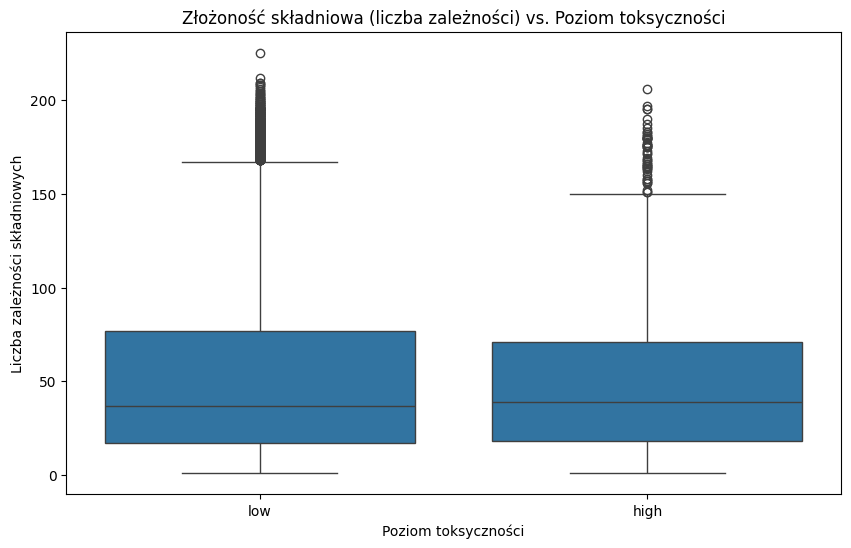

In [17]:
# Zadanie 1: Analiza zależności składniowych w komentarzach
def count_dependencies(text):
    doc = nlp(text)
    return len([token for token in doc if token.dep_ != 'punct'])

def plot_dependency_boxplot(df):
    df['dependency_count'] = df['comment_text'].apply(count_dependencies)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x='toxicity_level', y='dependency_count', data=df)
    plt.title('Złożoność składniowa (liczba zależności) vs. Poziom toksyczności')
    plt.xlabel('Poziom toksyczności')
    plt.ylabel('Liczba zależności składniowych')
    plt.show()

plot_dependency_boxplot(df)



 Zadanie 2: Identyfikacja kluczowych czynników toksyczności na podstawie NER i zależności składniowych
Przeanalizuj najbardziej toksyczne komentarze pod kątem nazwanych jednostek (NER) oraz zależności składniowych (dependency parsing). Zidentyfikuj, jakie nazwane jednostki są najczęściej w toksycznych komentarzach i w jaki sposób struktura zależności przyczynia się do toksyczności. Przedstaw wyniki w postaci drzew zależności i statystyk.

In [18]:
# Zadanie 2: Analiza toksycznych komentarzy na podstawie NER i zależności składniowych
def extract_named_entities(texts):
    entities = []
    for text in texts:
        doc = nlp(text)
        entities.extend([(ent.text, ent.label_) for ent in doc.ents])
    return Counter(entities)

def display_dependency_trees(texts, sample_size=3):
    for text in texts[:sample_size]:
        doc = nlp(text)
        displacy.render(doc, style='dep', jupyter=True)

def analyze_toxicity_factors(df):
    high_toxicity_comments = df[df['toxicity_level'] == 'high']['comment_text']
    most_common_entities = extract_named_entities(high_toxicity_comments).most_common(10)
    print("Najczęściej występujące jednostki w toksycznych komentarzach:")
    for entity, count in most_common_entities:
        print(f"{entity[0]} ({entity[1]}): {count}")
    print("\nDrzewa zależności dla wybranych komentarzy:")
    display_dependency_trees(high_toxicity_comments.tolist())

analyze_toxicity_factors(df)


Najczęściej występujące jednostki w toksycznych komentarzach:
Trump (ORG): 137
one (CARDINAL): 32
Canada (GPE): 28
first (ORDINAL): 27
Canadians (NORP): 25
American (NORP): 19
Canadian (NORP): 17
Muslim (NORP): 16
Alaska (GPE): 16
Muslims (NORP): 15

Drzewa zależności dla wybranych komentarzy:


Zadanie 3: Analiza stylu narracyjnego na podstawie zależności składniowych
Przeprowadź analizę zależności składniowych dla zdań z obu książek. Porównaj złożoność składniową obu tekstów (np. liczba podmiotów, dopełnień, orzeczeń w jednym zdaniu) i przedstaw wyniki na wykresach oraz wizualizacjach drzew składniowych.

Statystyki dla Anna Karenina: {'subjects': 39148, 'objects': 19956, 'verbs': 53566}
Statystyki dla Jane Eyre: {'subjects': 21860, 'objects': 11495, 'verbs': 27575}


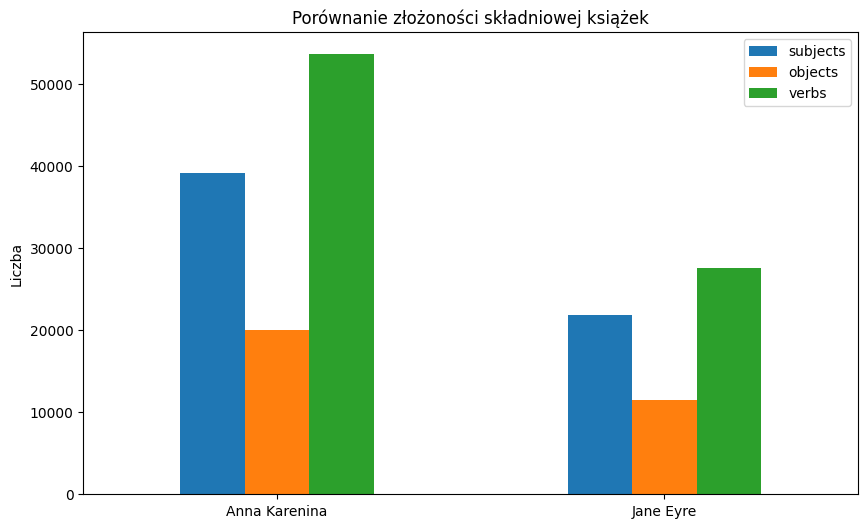

Drzewa zależności dla Anna Karenina:


Drzewa zależności dla Jane Eyre:


In [20]:
# Zadanie 3: Porównanie stylu narracyjnego na podstawie zależności składniowych
def analyze_syntactic_complexity(text):
    doc = nlp(text)
    return {
        'subjects': len([token for token in doc if token.dep_ == 'nsubj']),
        'objects': len([token for token in doc if token.dep_ == 'dobj']),
        'verbs': len([token for token in doc if token.pos_ == 'VERB'])
    }

def compare_books(book1_text, book2_text):
    book1_stats = analyze_syntactic_complexity(book1_text)
    book2_stats = analyze_syntactic_complexity(book2_text)
    print("Statystyki dla Anna Karenina:", book1_stats)
    print("Statystyki dla Jane Eyre:", book2_stats)

    # Wizualizacja statystyk
    df_stats = pd.DataFrame([book1_stats, book2_stats], index=['Anna Karenina', 'Jane Eyre'])
    df_stats.plot(kind='bar', figsize=(10, 6))
    plt.title('Porównanie złożoności składniowej książek')
    plt.ylabel('Liczba')
    plt.xticks(rotation=0)
    plt.show()

    # Drzewa zależności dla fragmentów
    print("Drzewa zależności dla Anna Karenina:")
    display_dependency_trees([book1_text[:1000]])
    print("Drzewa zależności dla Jane Eyre:")
    display_dependency_trees([book2_text[:1000]])

compare_books(book1_text, book2_text)


Zadanie 4: Analiza tematyczna na podstawie NER i lematyzacji – porównanie podejścia do postaci i miejsc w obu książkach
Wykorzystaj NER i lematyzację, aby porównać, w jaki sposób "Anna Karenina" i "Jane Eyre" traktują postaci i miejsca. Zidentyfikuj najczęściej wspominane jednostki i zanalizuj ich kontekst. Wyniki przedstaw w formie chmur słów i raportu porównawczego.

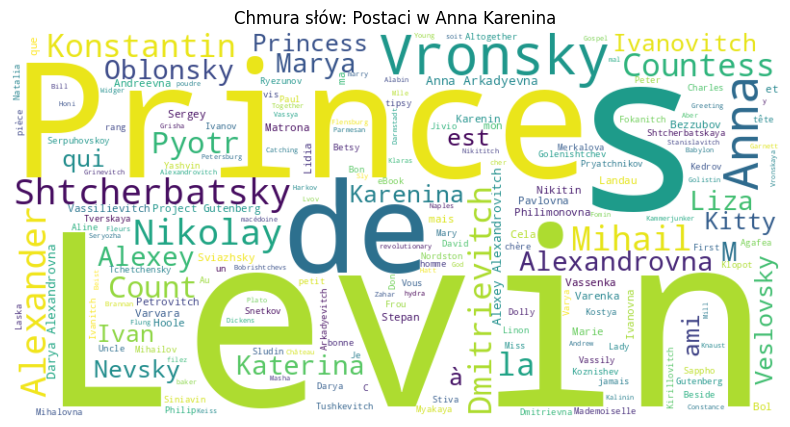

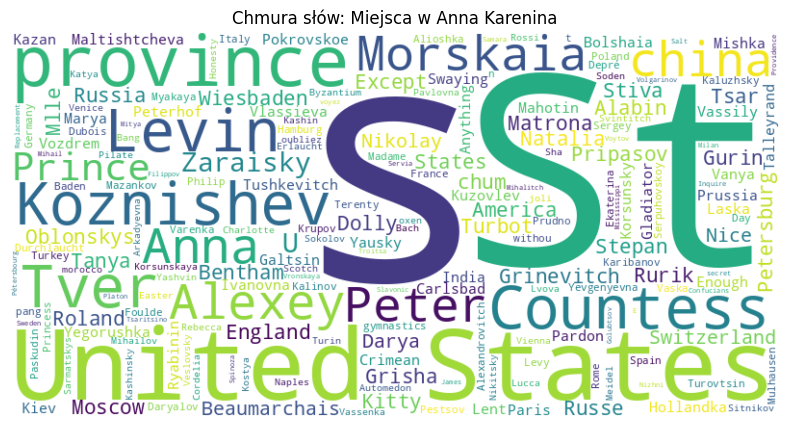

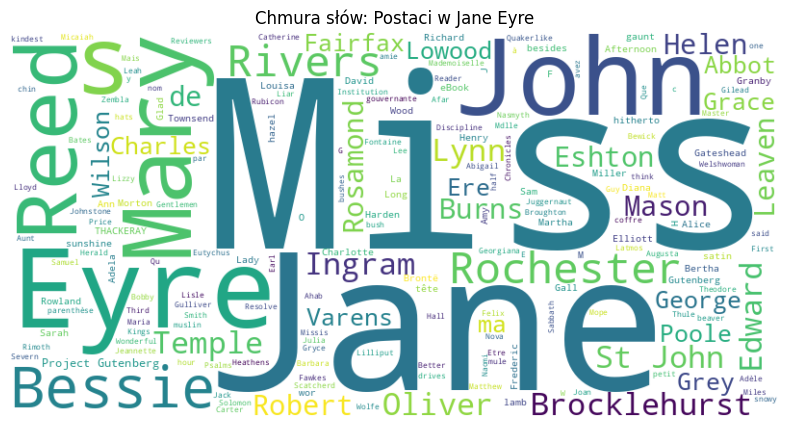

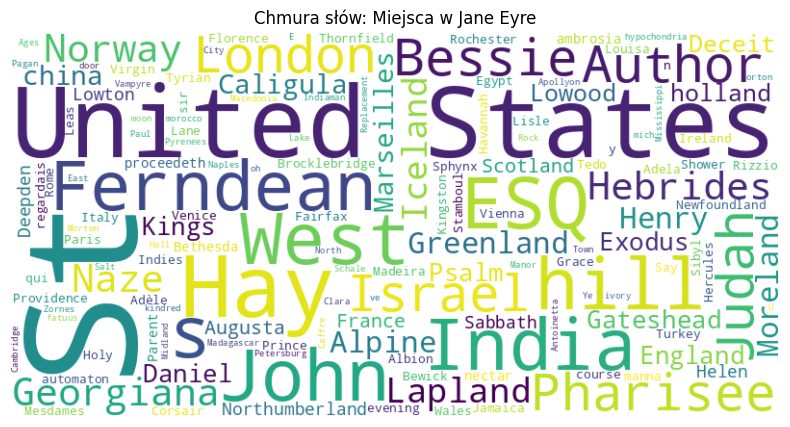

In [15]:
# Zadanie 4: Analiza tematyczna
def split_large_text(text, limit=100000):
    return [text[i:i+limit] for i in range(0, len(text), limit)]

def generate_wordcloud(entities, label, title):
    words = ' '.join([ent[0] for ent in entities if ent[1] == label])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def thematic_analysis(book1_fragments, book2_fragments):
    entities_book1 = extract_named_entities(book1_fragments)
    entities_book2 = extract_named_entities(book2_fragments)

    generate_wordcloud(entities_book1, 'PERSON', "Chmura słów: Postaci w Anna Karenina")
    generate_wordcloud(entities_book1, 'GPE', "Chmura słów: Miejsca w Anna Karenina")
    generate_wordcloud(entities_book2, 'PERSON', "Chmura słów: Postaci w Jane Eyre")
    generate_wordcloud(entities_book2, 'GPE', "Chmura słów: Miejsca w Jane Eyre")

# Wykonanie zadania 4
book1_fragments = split_large_text(book1_text)
book2_fragments = split_large_text(book2_text)
thematic_analysis(book1_fragments, book2_fragments)
